# Imports

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
#from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC

%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import LogisticRegression and LinearRegression from sklearn.linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Prep, train test split

In [3]:
df = pd.read_csv('../data/athletes_clean_dummies.csv')

In [4]:
df.shape

(11251, 242)

In [131]:
df.isna().sum().sum()

0

In [132]:
df_w = df.loc[df['sex']=='female',:].copy()

In [133]:
df_w.shape

(5169, 242)

In [134]:
df_w.columns

Index(['id', 'name', 'sex', 'dob', 'height', 'weight', 'gold', 'silver',
       'bronze', 'nationality_ALB',
       ...
       'sport_sailing', 'sport_shooting', 'sport_table tennis',
       'sport_taekwondo', 'sport_tennis', 'sport_triathlon',
       'sport_volleyball', 'sport_weightlifting', 'sport_wrestling', 'age'],
      dtype='object', length=242)

In [135]:
df_w.drop(columns = ['id','name','dob'], inplace = True)

In [136]:
df_w.drop(columns = 'sex', inplace = True)

In [137]:
# make sure we have no object columns, everything already dummied
df_w.dtypes.value_counts()

int64      236
float64      2
dtype: int64

In [138]:
# creating target variable:

has_gold = []
for entry in df_w['gold']:
    if entry > 0:
        has_gold.append(1)
    else:
        has_gold.append(0)


In [139]:
len(has_gold)

5169

In [140]:
df_w['has_gold'] = has_gold

In [141]:
df_w['has_gold'].value_counts()

0    4878
1     291
Name: has_gold, dtype: int64

In [142]:
# very imbalanced classes! look out

In [143]:
# changing height to be in centimeters rather than meters, to get more interpretable model


In [144]:
height_cm = df_w['height']*100

In [145]:
df_w['height_cm'] = height_cm

In [146]:
# would also be interesting to have interaction term with height AND weight
df_w['height * weight'] = df_w['height'] * df_w['weight']

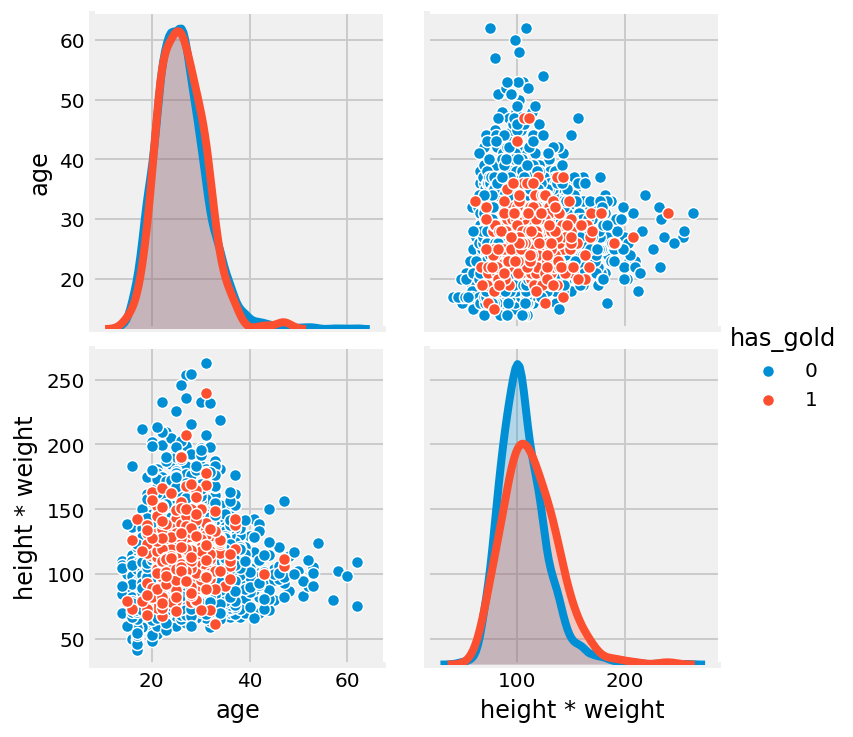

In [101]:
sns.pairplot(df_w[['age','height * weight','has_gold']], hue='has_gold')

In [148]:
X = df_w.drop(columns = ['gold','bronze','silver','has_gold','height'])
y = df_w['has_gold']

In [149]:
# Create training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   stratify = y,
                                                   random_state = 5)

In [150]:
X_train['weight']

8096     64.0
7524     49.0
6454     52.0
2704     52.0
230      59.0
         ... 
6202     64.0
2901     70.0
6673     68.0
1205     78.0
10998    63.0
Name: weight, Length: 3876, dtype: float64

In [151]:
# SCALING 
# should scale the float columns 

float_df = X.select_dtypes(include = 'float64')
cols_to_scale = float_df.columns

ss = StandardScaler()

for col in cols_to_scale:
    # DO NOT FIT TO TEST
    ss.fit(X[[col]])                         # learning mu and std
    X_train[col] = ss.transform(X_train[[col]])
    X_test[col] = ss.transform(X_test[[col]])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [154]:
X_train['weight']

8096     0.122979
7524    -1.229249
6454    -0.958803
2704    -0.958803
230     -0.327763
           ...   
6202     0.122979
2901     0.663871
6673     0.483574
1205     1.385059
10998    0.032831
Name: weight, Length: 3876, dtype: float64

# Baseline Model

In [186]:
y.value_counts(normalize = True)

0    0.943703
1    0.056297
Name: has_gold, dtype: float64

Wow, I have actually created a really difficult task for myself. **I need accuracy to be better than 94.37%.**

# Logistic Regression

This models assumes all the features are independent from one another when calculating the log odds. This is not true, since we made interaction terms. Also, there are trends amongst different sports (i.e. long distance runners probably weigh less than the average swimmer, so sport would not be independent from weight). Nonetheless, the model does well.

In [167]:
# Instantiate our model.
# this has an l2 regularization with C = 1 (default)
logreg = LogisticRegression(solver = 'lbfgs')

# Fit our model.
logreg.fit(X_train,y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [170]:
cross_val_score(logreg, X_train, y_train, cv = 5).mean()


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

0.9437565680079814

In [156]:
logreg.score(X_train, y_train)

0.9442724458204335

In [157]:
logreg.score(X_test, y_test)

0.9435421500386698

In [158]:
# exponentiating the coefficient to interpret it, 
# printing it out in order, labeled by what attribute it corresponds to 

coefs = pd.Series(np.exp(logreg.coef_[0]), index = X.columns)
coefs.sort_values()

nationality_NZL     0.358618
nationality_UKR     0.385183
nationality_FRA     0.424026
nationality_BLR     0.482120
sport_athletics     0.509174
                     ...    
nationality_GER     4.657160
nationality_CHN     4.746739
nationality_GBR     6.252493
nationality_RUS     9.508070
nationality_USA    10.632062
Length: 236, dtype: float64

In [159]:
coefs['age']

1.0153356512927374

In [160]:
coefs['height_cm']


1.302890211170065

As height increases by 1 meter, someone is 0.51 times as likely to have a gold medal.

This is not very useful! Maybe I should change meters to centimeters, and that way I'd get a more honest interpretation.

After the change: 
  
As height increases by 1 centimeter, someone is 1.3 times as likely to have a gold medal.

Well, we would expect more of a normal distribution, not monotone relationship with height.

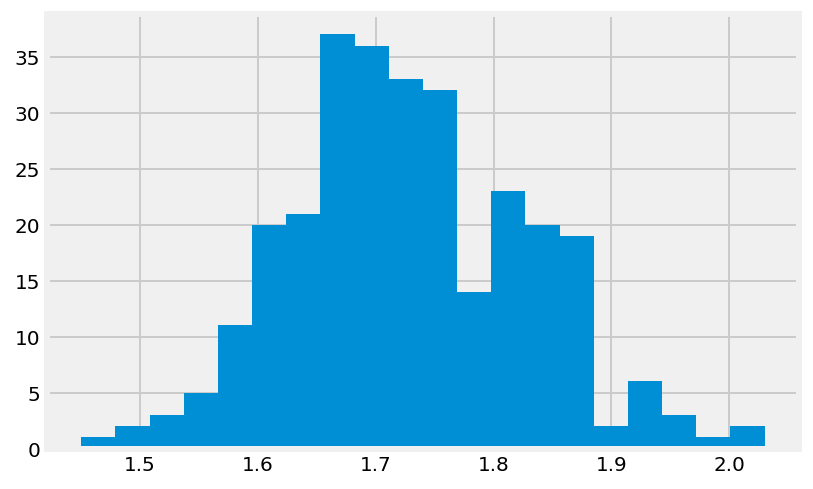

In [166]:
plt.hist(df_w.loc[df_w['has_gold'] == 1,:]['height'], bins = 20);

In [80]:
df_w.loc[df_w['has_gold'] == 1,:]['height'].median()

1.73

In [90]:
coefs['weight']

0.8288979084539088

In [91]:
coefs['nationality_USA']

9.473806142110597

A woman from the USA is 9.47 times as likely to get a gold medal!! Wow

In [92]:
coefs['height * weight']

1.10728507906731

#### PIPELINE AND GRIDSEARCH

In [187]:
# Instantiate pipeline object.
pipe = Pipeline([
    ('lr', LogisticRegression(solver = 'lbfgs'))
])

In [188]:
# Define dictionary of hyperparameters.
pipe_params = {
    'lr__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'lr__C' : [0.25, 0.5, 1, 2],
    'lr__max_iter': [100, 1000]
}

# 2*2*3*2*2 = 48 models

In [189]:
# Instantiate our GridSearchCV object.
gs = GridSearchCV(pipe, 
                  pipe_params, 
                  cv=5) # What number of folds in CV will we use?


In [190]:
gs.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale th

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/anaconda3/lib/python3.7/

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('lr',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='auto',
                                                           n_jobs=None,
                                                           penalty='l2',
                                                           random_state=None,
                                                  

In [191]:
gs.best_score_

0.9445307615563685

In [192]:
gs.best_params_

{'lr__C': 2, 'lr__max_iter': 1000, 'lr__penalty': 'l2'}

In [193]:
gs_model = gs.best_estimator_

In [194]:
gs_model.score(X_train, y_train)

0.9445304437564499

In [195]:
gs_model.score(X_test, y_test)

0.9435421500386698

# KNN

This is a *non-parametric* model, meaning that we make no assumptions about the distribution for our data. There are no coefficients for the different predictors and our estimate is not represented by a formula of our predictor variables.

In [171]:
# instantiate knn model

knn = KNeighborsClassifier()


In [172]:
cross_val_score(knn, X_train, y_train, cv = 5).mean()

0.9437562354506153

In [173]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [174]:
knn.score(X_train, y_train)

0.9509803921568627

In [175]:
knn.score(X_test, y_test)

0.9412219644238206

# SVM

We *assume* there exists a hyperplane that separates gold medalists from non gold medalists.

In [180]:
# Instantiate support vector machine.
svc = SVC()

cross_val_score(svc, X_train, y_train, cv = 5).mean()


0.9437565680079814

In [181]:
svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [182]:
svc.score(X_train, y_train)

0.9437564499484005

In [183]:
svc.score(X_test, y_test)

0.9435421500386698